In [2]:
# import libraries
import numpy as np
import pymc as pm
import pysmc as ps
from scipy.misc import logsumexp
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font',family='Times New Roman')
from pymc.Matplot import plot
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

import warnings
warnings.filterwarnings("ignore")

import cluster_model

In [3]:
global nparticles, ncluster, nsteps
global nfeature, nclass, nxi_c, nxi_s, npeople
global out_name, order

db_name = 'smc.h5'
out_name = db_name[:-3]

log_Z:  -542.350563353


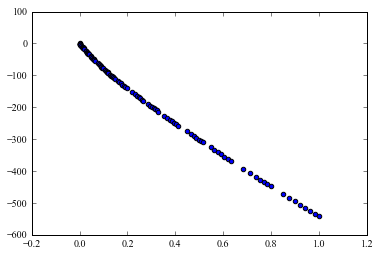

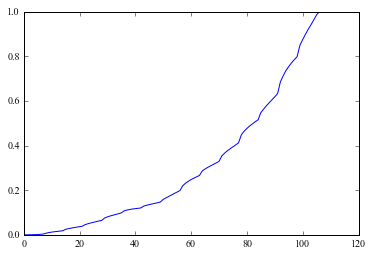

In [12]:
results_org = np.load(out_name+'.npz')
log_Zs = results_org['log_Zs']
gammas = results_org['gammas']

ncluster = results_org['ncluster']
nclass = results_org['nclass']
npeople = results_org['npeople']
nparticles = results_org['nparticles']

nxic = results_org['nxic']
nxis = results_org['nxis']


mu_samples = results_org['mu_samples']
sigma_samples = results_org['sigma_samples']
xi_cluster_samples = results_org['xi_cluster_samples']
xi_shared_samples = results_org['xi_shared_samples']
z_samples = results_org['z_samples']

print 'log_Z: ', log_Zs[-1]
plt.subplots()
plt.scatter(gammas,log_Zs)
plt.subplots()
plt.plot(gammas)

samples_org = [mu_samples, sigma_samples, xi_cluster_samples,xi_shared_samples, z_samples]
order = np.arange(ncluster)

In [13]:
try:
    results_relabeled = np.load(out_name+'_relabled.npz')

    mu_samples_relabeled = results_relabeled['mu_samples_reordered']
    sigma_samples_relabeled = results_relabeled['sigma_samples_reordered']
    xi_cluster_samples_relabeled = results_relabeled['xi_cluster_samples_reordered']
    xi_shared_samples_relabeled = results_relabeled['xi_shared_samples_reordered']
    z_samples_relabeled = results_relabeled['z_samples_reordered']

    samples_relabeled = [mu_samples_relabeled, sigma_samples_relabeled,
                         xi_cluster_samples_relabeled, xi_shared_samples_relabeled,
                         z_samples_relabeled]
except: pass

In [14]:
try:
    samples = samples_relabeled
except:
    samples = samples_org

In [24]:
# synthetic data generator for drawing probability curves
def SynData(num_datapoints=50, tr=22., vel=0.05, rh=50., met=1.2, clo=0.6):
    ta = np.linspace(16.,30.,num_datapoints)[:,None]
    tr = ta #tr * np.ones(num_datapoints,)[:,None]# 0.9235*ta+1.9595#
    vel = vel * np.ones(num_datapoints,)[:,None]# 0.0039*ta-0.0101#
    rh = rh * np.ones(num_datapoints,)[:,None]# 1.351*ta+13.836#
    met = met * np.ones(num_datapoints,)[:,None]# -0.0028*ta+1.1825#
    clo = clo * np.ones(num_datapoints,)[:,None]# -0.0172*ta+1.0499
    return np.hstack((ta, tr, vel, rh, met, clo))

def prob_dist(data=None, mu=None, sigma=None, xi_cluster=None, xi_shared=None):
    empty = np.zeros(data.shape[0])
    x = cluster_model.pmv_function(xi_cluster=xi_cluster, xi_shared=xi_shared, X=data)[:, None]/10.
    x = np.hstack((x, np.ones((x.shape[0],1))))
    prob = cluster_model.loglike_of_mlr(x, mu, sigma)
    prob = np.exp(prob)
    return prob

def plotting_prob_dist(ndata=50, vel=0.05, rh=50., met=1.2, clo=0.6, samples=None):
    global nparticles, ncluster, nclass
    syn = SynData(num_datapoints=ndata, vel=vel, rh=rh, met=met, clo=clo)
    
    mu_samples = samples[0]
    sigma_samples = samples[1]
    xi_cluster_samples =  samples[2]
    xi_shared_samples = samples[3]
    xi_cluster_org = np.array([[0., 0.],
                               [0.2, 5],
                               [0.3, 2.7]])
    xi_shared_org = np.array([1.,1.,1.])
    mu_org = np.array([[2, 0, -2],
                       [1.8, 0, -1.8],
                       [1.5, 0, -1.5]])
    sigma_org = np.array([0.9, 0.8, .66])
    
    prob = np.zeros((ncluster, nparticles, ndata, nclass))
    prob1 = np.zeros((ncluster, nparticles, ndata))
    prob2 = np.zeros((ncluster, nparticles, ndata))
    for k in xrange(ncluster):
        for i in xrange(nparticles):
            mu = mu_samples[order[k],i,:]
            sigma = sigma_samples[order[k],i]
            xi_cluster = xi_cluster_samples[order[k],i,:]
            xi_shared = xi_shared_samples[i,:]
            prob[order[k],i,:,:] = prob_dist(data=syn, mu=mu, sigma=sigma,xi_cluster = xi_cluster,
                                      xi_shared=xi_shared)
    prob_mean = np.average(prob,axis=1)
    
    print prob_mean.shape
    prob_l = np.percentile(prob, 2.5, axis=1)
    prob_u = np.percentile(prob, 97.5, axis=1)
    for k in xrange(ncluster):

        fig, ax = plt.subplots()
        fig.set_size_inches(3.9, 2.8, forward=True)
        ax.plot(syn[:,0], prob_mean[order[k],:,0], label='want cooler', color='b')
        ax.fill_between(syn[:,0],prob_l[order[k],:,0], prob_u[order[k],:,0], alpha=0.25, color='b')
        ax.plot(syn[:,0], prob_mean[order[k],:,1], label='no change', color='g')
        ax.fill_between(syn[:,0],prob_l[order[k],:,1], prob_u[order[k],:,1], alpha=0.25, color='g')
        ax.plot(syn[:,0], prob_mean[order[k],:,2], label='want warmer', color='r')
        ax.fill_between(syn[:,0],prob_l[order[k],:,2], prob_u[order[k],:,2], alpha=0.25, color='r')
        ax.tick_params(labelsize=8)
        ax.legend(loc='best', fontsize=8)
        ax.set_xlabel
        ax.set_xlim((16.,28.))
        ax.set_ylim((0.,1.))
        ax.set_xlabel('Air Temperature [$\degree$C]',fontsize=9)
        ax.xaxis.labelpad = 2
        ax.set_ylabel('Probability',fontsize=9)
        ax.set_ylabel('Probability',fontsize=9)
        if ncluster==3:
            pmv = cluster_model.pmv_function(xi_cluster=xi_cluster_org[k],
                                             xi_shared=xi_shared_org,
                                             X=syn)
            pmv = np.hstack([pmv[:,None]/10., np.ones((pmv.shape[0], 1))])
            prediction = np.exp(cluster_model.loglike_of_mlr(pmv, mu_org[k], sigma_org[k]))

            for c in xrange(nclass):
                ax.plot(syn[:,:1],prediction[:,c],'--')

        plt.savefig(out_name+'ProbDist_cluster_%d.png'%k, dpi=200, bbox_inches='tight', pad_inches=0.05)

def plotting_prob_z(samples):
    global ncluster, npeople
    if ncluster > 1:
        z_samples = samples[4]
        prob_z = np.zeros((npeople, ncluster))
        print prob_z.shape
        print z_samples.shape
        for k in xrange(ncluster):
            for d in xrange(npeople):
                prob_z[d,order[k]] = (z_samples[d,:]==order[k]).sum() / float(nparticles)
            fig, ax = plt.subplots()
            fig.set_size_inches(3.9, 2.8, forward=True)
            ax.scatter(np.arange(npeople)+1, prob_z[:,order[k]], c=prob_z[:,order[k]], cmap='coolwarm', s=50, vmin=0, vmax=1)
            ax.set_xlim(1-0.5, npeople+0.5)
            ax.set_xticks(np.arange(1,npeople,50))
            ax.set_ylim(-0.05, 1.05)
            ax.tick_params(labelsize=8)
            ax.set_xlabel('Occupant Index (1 to %d)'%npeople,fontsize=9)
            ax.set_ylabel('Probability',fontsize=9)
            plt.savefig(out_name+'Prob_z_%d.png'%k, dpi=200, bbox_inches='tight', pad_inches=0.05)
            
def scattered(samples):
    global ncluster, npeople
    mu_samples = samples[0]
    sigma_samples = samples[1]
    xi_cluster_samples = samples[2]
    xi_shared_samples = samples[3][:,:]
    xi_shared_samples_stack=np.array([xi_shared_samples for _ in xrange(ncluster)])
    ub = np.array([1.5 ,1.5, 1.5, 12.,  3., 10., 0.5, 1., 6.])
    lb = np.array([0.5, 0.5, 0.5 ,-5., -3., -1.,-0.5,-10., -0.5])
    mat = np.concatenate((xi_shared_samples_stack,
                          xi_cluster_samples,
                          mu_samples,
                          sigma_samples[:,:,None]), axis=2)
    nparams = mat.shape[2]
    print 'The number of parameters: ', nparams

    fig,ax=plt.subplots(nparams,nparams,figsize=(15,15))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    color = ['b','g','r','c','m','y','k']
    label = ['$\\xi_1$', '$\\xi_2$', '$\\xi_3$', '$\\xi_4$', '$\\xi_5$', '$\mu_3$', '$\mu_2$', '$\mu_1$', '$\sigma$']
    for i in xrange(nparams):
        for j in xrange(nparams):
            ax[i,j].set_xlim((lb[j],ub[j]))
            ax[i,j].set_xticks(np.arange(lb[j],ub[j]+(ub[j]-lb[j])/5.,(ub[j]-lb[j])/5.)[1:5])

            if i<j:
                ax[i,j].set_axis_off()

            if i>j:
                ax[i,j].set_ylim((lb[i],ub[i]))
                ax[i,j].set_yticks(np.arange(lb[i],ub[i]+(ub[i]-lb[i])/5.,(ub[i]-lb[i])/5.)[1:5])
                if i>2:
                    for k in xrange(ncluster):
                        ax[i,j].scatter(mat[order[k],:,j],mat[order[k],:,i], s=3, c=color[k], edgecolors='None')
                else:
                    ax[i,j].scatter(mat[0,:,j],mat[0,:,i], s=3, c='0.8', edgecolors='None')
                if i==nparams-1:
                    ax[i,j].set_xlabel(label[j],fontsize='xx-large',labelpad=1.5)
                if j==0:    
                    ax[i,j].set_ylabel(label[i],fontsize='xx-large')
                    ax[i,j].yaxis.set_label_coords(-0.3, 0.5)

            if i==j:
                ax[i,j].tick_params(labelleft='off')
                ax[i,j].tick_params(labelright='on')
                if i>2:
                    for k in xrange(ncluster):
                        ax[i,j].hist(mat[order[k],:,i], color=color[k],normed=True)
                else:
                        ax[i,j].hist(mat[0,:,i], color='0.8',normed=True)
                if i==nparams-1:
                    ax[i,j].set_xlabel(label[j],fontsize='xx-large',labelpad=1.5)
            if j!=0:
                ax[i,j].tick_params(labelleft='off')
            if i!=nparams-1:
                ax[i,j].tick_params(labelbottom='off')

    plt.savefig(out_name+'_scattered.png', dpi=200, bbox_inches='tight', pad_inches=0.05)

(2L, 50L, 3L)


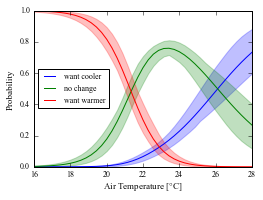

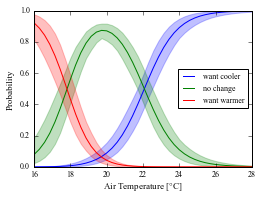

In [25]:
from ipywidgets import interactive, fixed
interactive(plotting_prob_dist,
            ndata=fixed(50), samples=fixed(samples),
            vel=(0.05,0.5,0.05), rh=(10.,100.,10.), met=(1.0,2.0,0.1), clo=(0.5,1.1,0.1))

(9L, 2L)
(9L, 100L)


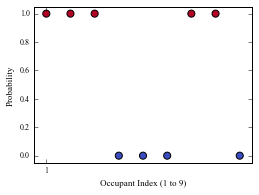

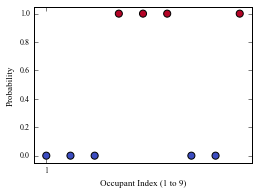

In [26]:
plotting_prob_z(samples)

The number of parameters:  9


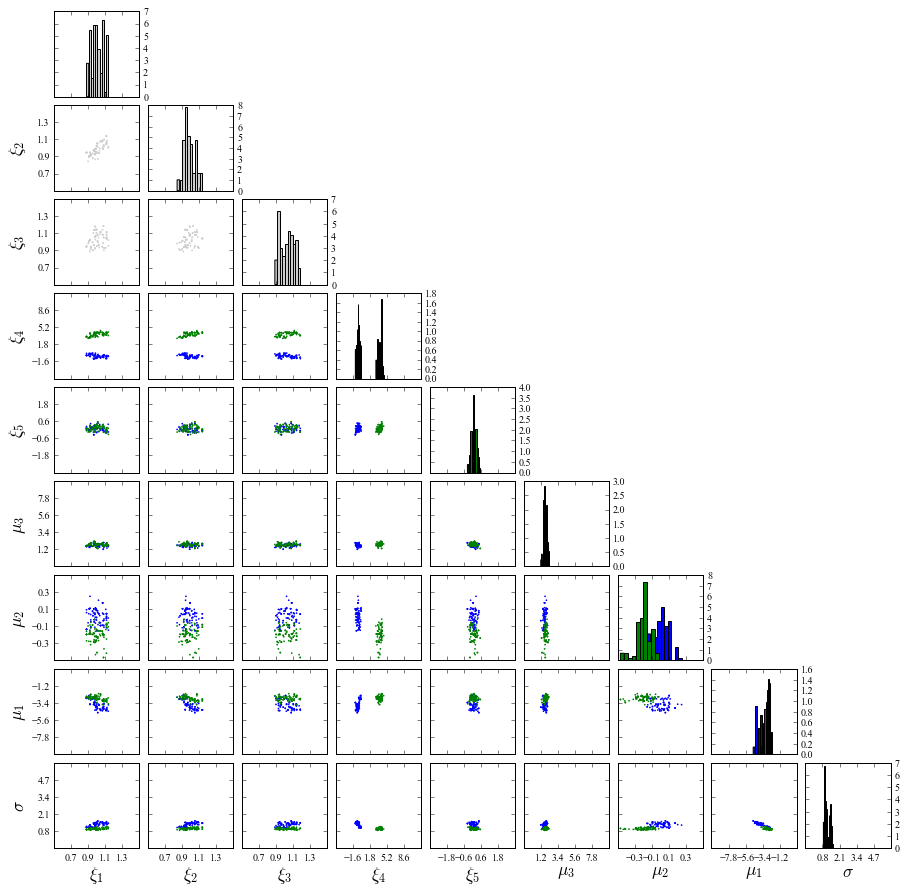

In [27]:
scattered(samples)

# Implementation

In [28]:
def infer_z(X=None, Y=None, mu_particles=None, sigma_particles=None, xi_cluster_particles=None, xi_shared_particles=None):
    nparticles = mu_particles.shape[0] # the number of particles
    w = 1./nparticles
    ntraining = X.shape[0] # the number of samples
    prob_z = np.zeros((ncluster,)) # P(z=k|data)
    for i in xrange(ncluster):
        likelihood = np.zeros((nparticles,))
        for j in xrange(nparticles):
            mu = mu_particles[i,j,:]
            sigma = sigma_particles[i,j]
            xi_cluster = xi_cluster_particles[i,j,:]
            xi_shared = xi_shared_particles[i,:]

            x = cluster_model.pmv_function(xi_cluster=xi_cluster, xi_shared=xi_shared, X=X)[:, None]/10.
            x = np.hstack((x, np.ones((x.shape[0],1))))
            likelihood[j] = np.exp((cluster_model.loglike_of_mlr(x, mu, sigma)[np.arange(ntraining),Y]).sum())
        prob_z[i] = (w*likelihood).sum()
    prob_z = prob_z / np.sum(prob_z)
    return prob_z

def predict_y(X_training=None, Y_training=None, X_validation=None,
              mu_particles=None, sigma_particles=None, xi_cluster_particles=None, xi_shared_particles=None):
    nparticles = mu_particles.shape[0]
    ntraining = X_training.shape[0]
    w = 1./nparticles
    
    likelihood_training = np.zeros((ncluster,nparticles))
    likelihood_validation = np.zeros((nclass,ncluster,nparticles))
    prob = np.zeros((nclass,))
    
    for k in xrange (ncluster):
        for i in xrange (nparticles):
            mu = mu_particles[k,i,:]
            sigma = sigma_particles[k,i]
            xi_cluster = xi_cluster_particles[k,i,:]
            xi_shared = xi_shared_particles[i,:]

            x_training = cluster_model.pmv_function(xi_cluster=xi_cluster, xi_shared=xi_shared, X=X_training)[:, None]/10.
            x_training = np.hstack((x_training, np.ones((x_training.shape[0],1))))
            
            x_validation = cluster_model.pmv_function(xi_cluster=xi_cluster, xi_shared=xi_shared, X=X_validation)[:, None]/10.
            x_validation = np.hstack((x_validation, np.ones((x_validation.shape[0],1))))            
            likelihood_training[k,i] = np.exp((cluster_model.loglike_of_mlr(x_training, mu, sigma)[np.arange(ntraining),Y_training]).sum())
            likelihood_validation[:,k,i] = np.exp(cluster_model.loglike_of_mlr(x_validation, mu, sigma))
    for j in xrange (nclass):
        prob[j] = np.array([(w*likelihood_validation[j,k,:]*likelihood_training[k,:]) for k in xrange(ncluster)]).sum()
    return prob / np.sum(prob)

In [32]:
mu_samples = samples[0]
sigma_samples = samples[1]
xi_cluster_samples = samples[2]
xi_shared_samples = samples[3]


data_file = os.path.join('..', 'data', 'ASHRAE_implement_training.npz')

dataset = np.load(data_file)
X_implement_training = dataset['X_implement_training']
Y_implement_training = dataset['Y_implement_training'].flatten()
occu_ID_implement_training = dataset['occu_ID_implement_training'].flatten()

npeople_implement = max(occu_ID_implement_training)+1
print 'The number of occupants in the implementation dataset :' ,npeople_implement
print ''


data_file_validation = os.path.join('..', 'data', 'ASHRAE_implement_validation.npz')

dataset_validation = np.load(data_file_validation)
X_implement_validation = dataset_validation['X_implement_validation']
Y_implement_validation = dataset_validation['Y_implement_validation'].flatten()
occu_ID_implement_validation = dataset_validation['occu_ID_implement_validation'].flatten()

The number of occupants in the implementation dataset : 11



## Training: Inferring occupants' cluster value z with training data

In [33]:
prob_z = np.zeros((npeople_implement,ncluster))
for i in xrange(npeople_implement):
    idx = occu_ID_implement_training==i
    X = X_implement_training[idx,:]
    Y = Y_implement_training[idx]
    prob_z[i,:] = infer_z(X=X, Y=Y, mu_particles=mu_samples, sigma_particles=sigma_samples,
                          xi_cluster_particles=xi_cluster_samples, xi_shared_particles=xi_shared_samples)

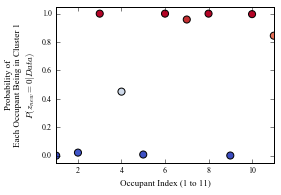

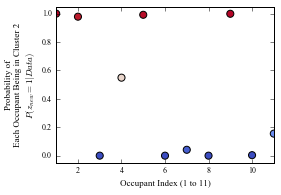

In [34]:
for k in xrange(ncluster):
    fig, ax = plt.subplots()
    fig.set_size_inches(3.9, 2.8, forward=True)
    ax.scatter(np.arange(npeople_implement)+1, prob_z[:,k], c=prob_z[:,k], cmap='coolwarm', s=50)
    ax.set_xlim(1, npeople_implement)
    ax.set_ylim(-0.05, 1.05)
    ax.tick_params(labelsize=8)
    ax.set_xlabel(('Occupant Index (1 to ' + str(npeople_implement) + ')'),fontsize=9)
    ax.set_ylabel('Probability of\nEach Occupant Being in Cluster ' + str(k+1) + '\n$P(z_{new}=' + str(k) + '|Data)$',fontsize=9)

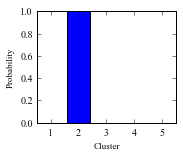

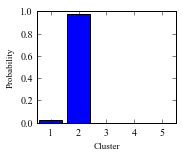

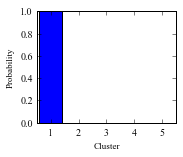

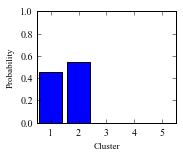

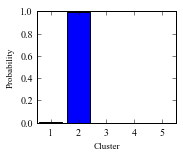

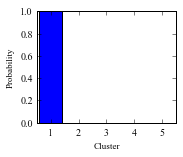

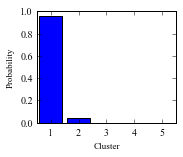

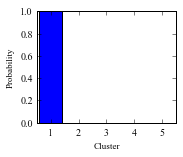

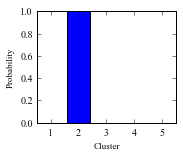

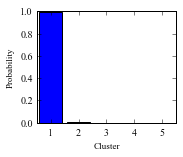

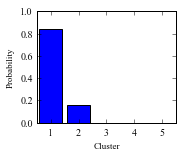

In [35]:
for i in xrange(npeople_implement):
    fig, ax = plt.subplots()
    fig.set_size_inches(2.5, 2, forward=True)
    plt.bar(np.arange(ncluster)+1-0.4,prob_z[i,order])
    plt.ylim((0.,1.))
    plt.xlim((0.5,5.5))
    plt.ylabel('Probability',size=9)
    plt.xlabel('Cluster',size=9)
    plt.savefig('Prob_z_NewOcc_%d.png'%i, dpi=200, bbox_inches='tight', pad_inches=0.05)

## Validation: Predicting occupants' thermal preference for validation data

In [36]:
loglik = []
print xi_shared_samples.shape
for d in xrange(npeople_implement):
    print 'occupant #' + str(d)
    idx_training = occu_ID_implement_training==d
    X_training = X_implement_training[idx_training,:]
    Y_training = Y_implement_training[idx_training]
    
    idx_validation = occu_ID_implement_validation==d
    X_validation = X_implement_validation[idx_validation,:]
    Y_validation = Y_implement_validation[idx_validation]
    nvalidation = X_validation.shape[0]
    for v in xrange (nvalidation):
        prob_y = predict_y(X_training=X_training,
                           Y_training=Y_training,
                           X_validation=X_validation[v:v+1,:],
                           mu_particles=mu_samples,
                           sigma_particles=sigma_samples,
                           xi_cluster_particles=xi_cluster_samples,
                           xi_shared_particles=xi_shared_samples)
        loglik.append(np.log(prob_y[Y_validation[v]]))

(100L, 3L)
occupant #0
occupant #1
occupant #2
occupant #3
occupant #4
occupant #5
occupant #6
occupant #7
occupant #8
occupant #9
occupant #10


In [37]:
ndata_validation = X_implement_validation.shape[0]

loglik = np.sum(loglik)

loglik_random = np.log(np.ones((ndata_validation,)) * 1./3.).sum()

prob_naive = np.vstack([[0.272727272727, 0.5, 0.227272727273]]*ndata_validation).T

loglik_naive = prob_naive[Y_implement_validation,np.arange(ndata_validation)]
loglik_naive = np.log(loglik_naive).sum()

loglik_perfect = np.log(np.ones((ndata_validation,))).sum()

print 'logloss of cluster model : ' + str(loglik)
print 'logloss of random model : ' + str(loglik_random)
print 'logloss of naive model : ' + str(loglik_naive)

1.-(loglik/loglik_random)

logloss of cluster model : -58.3350880145
logloss of random model : -38.4514301034
logloss of naive model : -34.3869465807


-0.51711101141452698

In [38]:
mu_samples = samples[0]
sigma_samples = samples[1]
xi_converted_samples = samples[2]

prob_y_people = []
for d in xrange(npeople_implement):
    print 'occupant #' + str(d)
    idx_training = occu_ID_implement_training==d
    X_training = X_implement_training[idx_training,:]
    Y_training = Y_implement_training[idx_training]
    X_validation = SynData(num_datapoints=100)
    nvalidation = X_validation.shape[0]
    prob_y = np.zeros((nvalidation,3))
    for v in xrange (nvalidation):
        prob_y[v,:] = predict_y(X_training=X_training, Y_training=Y_training,
                                X_validation=X_validation[v:v+1,:],
                                mu_particles=mu_samples,
                                sigma_particles=sigma_samples,
                                xi_cluster_particles=xi_cluster_samples,
                                xi_shared_particles=xi_shared_samples)
    prob_y_people.append(prob_y)

occupant #0
occupant #1
occupant #2
occupant #3
occupant #4
occupant #5
occupant #6
occupant #7
occupant #8
occupant #9
occupant #10


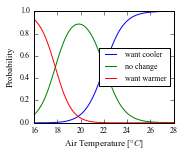

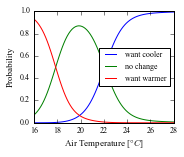

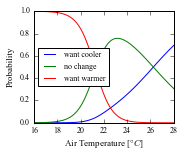

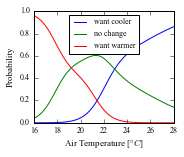

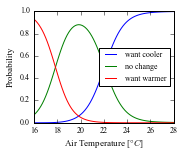

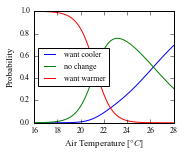

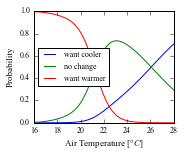

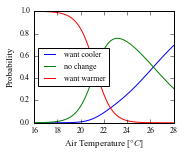

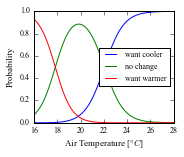

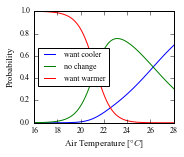

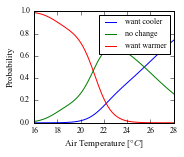

In [39]:
for d in xrange(npeople_implement):
    prob_y = prob_y_people[d]
    fig, ax = plt.subplots()
    fig.set_size_inches(2.5, 2, forward=True)
    ax.plot(X_validation[:,0], prob_y[:,0], label='want cooler', color='b')
    ax.plot(X_validation[:,0], prob_y[:,1], label='no change', color='g')
    ax.plot(X_validation[:,0], prob_y[:,2], label='want warmer', color='r')
    ax.tick_params(labelsize=8)
    ax.legend(loc='best', fontsize=8)
    ax.set_xlabel
    ax.set_xlim((16.,28.))
    ax.set_ylim((0.,1.))
    ax.set_xlabel('Air Temperature [$\degree C$]',fontsize=9)
    ax.xaxis.labelpad = 2
    ax.set_ylabel('Probability',fontsize=9)
    plt.savefig('ProbDist_NewOcc_%d.png'%d, dpi=200, bbox_inches='tight', pad_inches=0.05)

In [21]:
from sklearn.linear_model import LogisticRegression
X_training_daum = np.array([15,16,17,18,19,
                            18,19,20,21,22,23,24,25,26,27,28,29,
                            28,29,30,31,32]).astype(float)[:,None]
Y_training_daum = np.array([2,2,2,2,2,
                            1,1,1,1,1,1,1,1,1,1,1,1,
                            0,0,0,0,0])
loglik_daum = []
for d in xrange(npeople_implement):
    idx_training = occu_ID_implement_training==d
    X_training = np.vstack((X_training_daum, X_implement_training[idx_training,:1]))
    Y_training = np.hstack((Y_training_daum, Y_implement_training[idx_training]))
    
    
    lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
    lr.fit(X_training, Y_training)
    
    idx_validation = occu_ID_implement_validation==d
    X_validation = X_implement_validation[idx_validation,:1]
    Y_validation = Y_implement_validation[idx_validation]
    
    nvalidation = X_validation.shape[0]
    prob_y = np.zeros((nvalidation,3))

    for v in xrange (nvalidation):
        prob_y[v,:] = lr.predict_proba(X_validation[v]).flatten()

    for v in xrange (nvalidation):
        prob_y[v,:] = lr.predict_proba(X_validation[v]).flatten()
        loglik_daum.append(np.log(prob_y[v,:][Y_validation[v]]))

loglik_daum = np.sum(loglik_daum)
print 'logloss of Daum\'s model : ' + str(loglik_daum)

logloss of Daum's model : -29.9303401113
